In [1]:
# We have used the glove.6B.300d for our model. The path for this embedding file has to be set on the 
#‘glove_path’ variable which is below the ‘load_glove_embeddings’ function.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [36]:
trainSet = pd.read_csv('train_all_tasks.csv')

#trainSet = pd.read_csv('Desktop\\CSE440 Project\\train_all_tasks.csv') #if opened after uploading in jupyter notebook and 
                                                                        #located the submission folder in desktop homepage
trainSet.head()



,rewire_id,text,label_sexist,label_category,label_vector
0,sexism2022_english-7358,"Damn, this writing was pretty chaotic",not sexist,none,none
1,sexism2022_english-2367,"Yeah, and apparently a bunch of misogynistic v...",not sexist,none,none
2,sexism2022_english-3073,How the FUCK is this woman still an MP!!!???,not sexist,none,none
3,sexism2022_english-14895,Understand. Know you're right. At same time I ...,not sexist,none,none
4,sexism2022_english-4118,Surprized they didn't stop and rape some women,not sexist,none,none


In [4]:
text = trainSet['text']
trainSet['label_sexist'] = trainSet['label_sexist'].map({'not sexist': 0, 'sexist': 1})
labels = trainSet['label_sexist']
trainSet = trainSet.drop('label_vector', axis=1)

In [5]:
trainSet.shape

(14000, 4)

In [6]:
print(trainSet['label_sexist'].value_counts())
print(trainSet['label_category'].value_counts())
print(labels)

0    10602
1     3398
Name: label_sexist, dtype: int64
none                                        10602
2. derogation                                1590
3. animosity                                 1165
4. prejudiced discussions                     333
1. threats, plans to harm and incitement      310
Name: label_category, dtype: int64
0        0
1        0
2        0
3        0
4        0
        ..
13995    1
13996    0
13997    0
13998    0
13999    0
Name: label_sexist, Length: 14000, dtype: int64


In [7]:
trainSet['word_length'] = trainSet['text'].apply(lambda x: len(x.split()))
max_word_length = trainSet['word_length'].max()
print("Maximum word length:", max_word_length)

Maximum word length: 55


In [8]:
from sklearn.model_selection import train_test_split

# Splitting the data into training, validation, and test sets
X_train, X_val_test, y_train, y_val_test = train_test_split(text, labels, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)


print("Training data shape:", X_train.shape, y_train.shape)
print("Validation data shape:", X_val.shape, y_val.shape)
print("Test data shape:", X_test.shape, y_test.shape)

Training data shape: (11200,) (11200,)
Validation data shape: (1400,) (1400,)
Test data shape: (1400,) (1400,)


In [9]:
# Defining pre-processing parameters
max_len = 100
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # out of vocabulary token
vocab_size = 5000
print(vocab_size)


5000


In [10]:
tokenizer = Tokenizer(num_words = vocab_size,
                      char_level = False,
                      oov_token = oov_tok)
tokenizer.fit_on_texts(X_train)



In [11]:
word_index = tokenizer.word_index
total_words = len(word_index)
total_words

20099

In [12]:
sequences = tokenizer.texts_to_sequences(X_train)
data_padded_train = pad_sequences(sequences, maxlen=max_len, padding = padding_type, truncating = trunc_type)

print(text[2])
print(sequences[2])
print(len(data_padded_train[2]))

How the FUCK is this woman still an MP!!!???
[117, 6, 2077, 28, 3, 720, 108, 3694, 261, 7, 136, 1945, 32, 993, 35, 7, 17, 1, 4, 349, 488, 63, 141, 256, 3, 140, 807, 9, 82, 12, 19, 1712]
100


In [13]:

sequences2 = tokenizer.texts_to_sequences(X_val)
data_padded_val = pad_sequences(sequences2,
                               maxlen = max_len,
                               padding = padding_type,
                               truncating = trunc_type)

sequences3 = tokenizer.texts_to_sequences(X_test)
data_padded_test = pad_sequences(sequences3,
                               maxlen = max_len,
                               padding = padding_type,
                               truncating = trunc_type)

In [14]:
print('Shape of training tensor: ', data_padded_train.shape)
print('Shape of validation tensor: ', data_padded_val.shape)
print('Shape of testing tensor: ', data_padded_test.shape)

Shape of training tensor:  (11200, 100)
Shape of validation tensor:  (1400, 100)
Shape of testing tensor:  (1400, 100)


In [15]:
# Load GloVe embeddings
def load_glove_embeddings(path):
    embeddings_index = {}
    with open(path, 'r', encoding='utf-8', errors='replace') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

glove_path = 'E:/8th semester/CSE440/New folder/glove.6B/glove.6B.300d.txt' #paste the embedding file path here
glove_embeddings = load_glove_embeddings(glove_path)


In [16]:
# Prepare GloVe embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


vocab_size = len(word_index) + 1

In [17]:
print(y_train.value_counts())

0    8506
1    2694
Name: label_sexist, dtype: int64


In [18]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [19]:
# model with dense layers

embedding_dim = 300
vocab_size = len(word_index) + 1
drop_val = 0.2

model2 = Sequential()
model2.add(Embedding(vocab_size,
                     embedding_dim,
                     weights=[embedding_matrix],
                     input_length=100,
                     trainable= False))

model2.add(Dense(24, activation='relu'))
model2.add(Dropout(drop_val))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          6030000   
                                                                 
 dense (Dense)               (None, 100, 24)           7224      
                                                                 
 dropout (Dropout)           (None, 100, 24)           0         
                                                                 
 dense_1 (Dense)             (None, 100, 1)            25        
                                                                 
Total params: 6,037,249
Trainable params: 7,249
Non-trainable params: 6,030,000
_________________________________________________________________


In [20]:

import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

Epoch 1/20
350/350 [==============================] - 4s 8ms/step - loss: 0.5779 - accuracy: 0.7591 - val_loss: 0.5647 - val_accuracy: 0.7478
Epoch 2/20
350/350 [==============================] - 2s 7ms/step - loss: 0.5526 - accuracy: 0.7601 - val_loss: 0.5644 - val_accuracy: 0.7479
Epoch 3/20
350/350 [==============================] - 2s 6ms/step - loss: 0.5520 - accuracy: 0.7602 - val_loss: 0.5642 - val_accuracy: 0.7479
Epoch 4/20
350/350 [==============================] - 2s 6ms/step - loss: 0.5517 - accuracy: 0.7602 - val_loss: 0.5638 - val_accuracy: 0.7479
Epoch 5/20
350/350 [==============================] - 2s 6ms/step - loss: 0.5518 - accuracy: 0.7603 - val_loss: 0.5643 - val_accuracy: 0.7479
Epoch 6/20
350/350 [==============================] - 2s 7ms/step - loss: 0.5512 - accuracy: 0.7603 - val_loss: 0.5652 - val_accuracy: 0.7480
Training Accuracy: 0.7603
Testing Accuracy:  0.7507


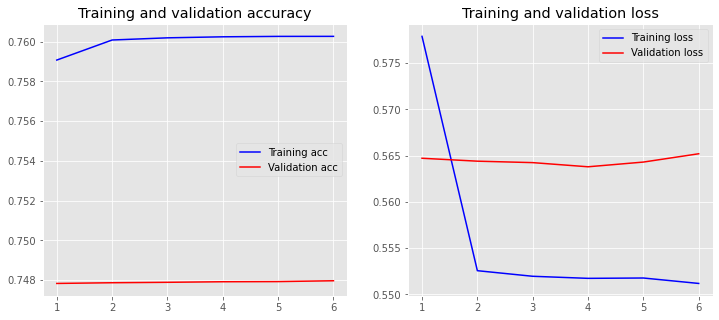

In [21]:
# Train the shallow model
history = model2.fit(data_padded_train, y_train, epochs=20, validation_data=(data_padded_val, y_val), callbacks=[early_stopping])


loss2,accuracy2 = model2.evaluate(data_padded_train, y_train, verbose = False)
print("Training Accuracy: {:.4f}".format(accuracy2))
loss2,accuracy2 = model2.evaluate(data_padded_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy2))


plot_history(history)

In [22]:
# LSTM model
model3 = Sequential()
model3.add(Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], input_length=100, trainable=True))
model3.add(LSTM(128))
model3.add(Dropout(0.2))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          6030000   
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 6,249,777
Trainable params: 6,249,777
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
350/350 [==============================] - 61s 162ms/step - loss: 0.5573 - accuracy: 0.7593 - val_loss: 0.5717 - val_accuracy: 0.7471
Epoch 2/20
350/350 [==============================] - 56s 159ms/step - loss: 0.5541 - accuracy: 0.7595 - val_loss: 0.5662 - val_accuracy: 0.7471
Epoch 3/20
350/350 [==============================] - 55s 159ms/step - loss: 0.5538 - accuracy: 0.7595 - val_loss: 0.5663 - val_accuracy: 0.7471
Epoch 4/20
350/350 [==============================] - 54s 154ms/step - loss: 0.5537 - accuracy: 0.7595 - val_loss: 0.5662 - val_accuracy: 0.7471
Epoch 5/20
350/350 [==============================] - 61s 175ms/step - loss: 0.5538 - accuracy: 0.7595 - val_loss: 0.5667 - val_accuracy: 0.7471
Epoch 6/20
350/350 [==============================] - 55s 158ms/step - loss: 0.5532 - accuracy: 0.7595 - val_loss: 0.5658 - val_accuracy: 0.7471
Epoch 7/20
350/350 [==============================] - 58s 167ms/step - loss: 0.5532 - accuracy: 0.7595 - val_loss: 0.5665 - val_ac

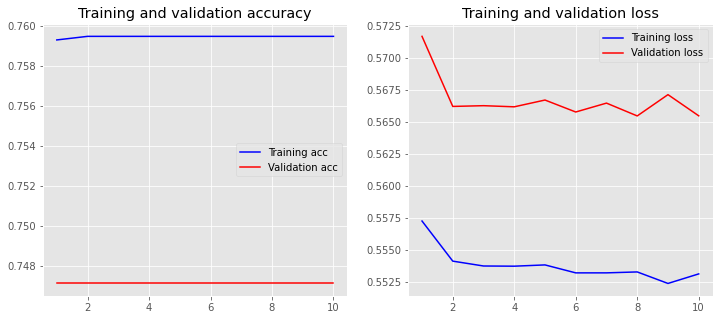

In [23]:
# Train the LSTM model
history2 = model3.fit(data_padded_train, y_train, epochs=20, validation_data=(data_padded_val, y_val), callbacks=[early_stopping])

loss3,accuracy3 = model3.evaluate(data_padded_train, y_train, verbose = False)
print("Training Accuracy: {:.4f}".format(accuracy3))
loss3,accuracy3 = model3.evaluate(data_padded_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy3))


plot_history(history2)

In [24]:
# Bidirectional LSTM model
model4 = Sequential()
model4.add(Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], input_length=100, trainable=True))
model4.add(Bidirectional(LSTM(128)))
model4.add(Dropout(0.2))
model4.add(Dense(1, activation='sigmoid'))
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 300)          6030000   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              439296    
 l)                                                              
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 6,469,553
Trainable params: 6,469,553
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
350/350 [==============================] - 103s 276ms/step - loss: 0.4725 - accuracy: 0.7958 - val_loss: 0.4525 - val_accuracy: 0.8221
Epoch 2/20
350/350 [==============================] - 90s 258ms/step - loss: 0.3379 - accuracy: 0.8612 - val_loss: 0.4096 - val_accuracy: 0.8286
Epoch 3/20
350/350 [==============================] - 93s 265ms/step - loss: 0.2563 - accuracy: 0.8967 - val_loss: 0.4324 - val_accuracy: 0.8264
Epoch 4/20
350/350 [==============================] - 93s 264ms/step - loss: 0.1959 - accuracy: 0.9256 - val_loss: 0.4840 - val_accuracy: 0.8121
Training Accuracy: 0.9041
Testing Accuracy:  0.8157


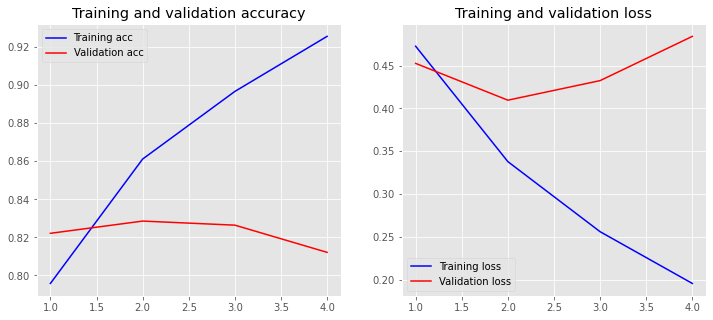

In [25]:
history3 = model4.fit(data_padded_train, y_train, epochs=20, validation_data=(data_padded_val, y_val), callbacks=[early_stopping])

loss4,accuracy4 = model4.evaluate(data_padded_train, y_train, verbose = False)
print("Training Accuracy: {:.4f}".format(accuracy4))
loss4,accuracy4 = model4.evaluate(data_padded_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy4))


plot_history(history3)

In [26]:
from sklearn.metrics import classification_report, confusion_matrix

loss, accuracy = model4.evaluate(data_padded_test, y_test, verbose=0)

y_pred = np.round(model4.predict(data_padded_test)).astype(int)

conf_matrix = confusion_matrix(y_test, y_pred)

precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
f1_score = 2 * (precision * recall) / (precision + recall)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nPrecision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

report = classification_report(y_test, y_pred, target_names=['class 0', 'class 1'])
print("\nClassification Report:")
print(report)

44/44 [==============================] - 5s 72ms/step
Test Loss: 0.41155895590782166
Test Accuracy: 0.8157142996788025

Confusion Matrix:
[[944 106]
 [152 198]]

Precision: 0.6513157894736842
Recall: 0.5657142857142857
F1-score: 0.6055045871559632

Classification Report:
              precision    recall  f1-score   support

     class 0       0.86      0.90      0.88      1050
     class 1       0.65      0.57      0.61       350

    accuracy                           0.82      1400
   macro avg       0.76      0.73      0.74      1400
weighted avg       0.81      0.82      0.81      1400



Task B


In [27]:

trainSet.head()

,rewire_id,text,label_sexist,label_category,word_length
0,sexism2022_english-7358,"Damn, this writing was pretty chaotic",0,none,6
1,sexism2022_english-2367,"Yeah, and apparently a bunch of misogynistic v...",0,none,18
2,sexism2022_english-3073,How the FUCK is this woman still an MP!!!???,0,none,9
3,sexism2022_english-14895,Understand. Know you're right. At same time I ...,0,none,25
4,sexism2022_english-4118,Surprized they didn't stop and rape some women,0,none,8


In [28]:
from sklearn.preprocessing import LabelEncoder

label_encoder_taskB = LabelEncoder()


labels2 = label_encoder_taskB.fit_transform(trainSet['label_category'])
print(labels2)

y_train2, y_val_test2 = train_test_split(labels2, test_size=0.2, random_state=42)
y_test2, y_val2 = train_test_split(y_val_test2, test_size=0.5, random_state=42)



print("Training data shape:", X_train.shape, y_train2.shape)
print("Validation data shape:", X_val.shape, y_val2.shape)
print("Test data shape:", X_test.shape, y_test2.shape)

[4 4 4 ... 4 4 4]
Training data shape: (11200,) (11200,)
Validation data shape: (1400,) (1400,)
Test data shape: (1400,) (1400,)


In [29]:

model5 = Sequential()
model5.add(Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], input_length=100, trainable=True))
model5.add(LSTM(128))
model5.add(Dropout(0.2))
model5.add(Dense(5, activation='softmax'))
model5.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model5.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 300)          6030000   
                                                                 
 lstm_2 (LSTM)               (None, 128)               219648    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 5)                 645       
                                                                 
Total params: 6,250,293
Trainable params: 6,250,293
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
350/350 [==============================] - 61s 162ms/step - loss: 0.8575 - accuracy: 0.7579 - val_loss: 0.8795 - val_accuracy: 0.7471
Epoch 2/20
350/350 [==============================] - 54s 153ms/step - loss: 0.8403 - accuracy: 0.7595 - val_loss: 0.8726 - val_accuracy: 0.7471
Epoch 3/20
350/350 [==============================] - 52s 148ms/step - loss: 0.8379 - accuracy: 0.7595 - val_loss: 0.8647 - val_accuracy: 0.7471
Epoch 4/20
350/350 [==============================] - 52s 150ms/step - loss: 0.8376 - accuracy: 0.7595 - val_loss: 0.8697 - val_accuracy: 0.7471
Epoch 5/20
350/350 [==============================] - 52s 148ms/step - loss: 0.8373 - accuracy: 0.7595 - val_loss: 0.8680 - val_accuracy: 0.7471
Training Accuracy: 0.7595
Testing Accuracy:  0.7500


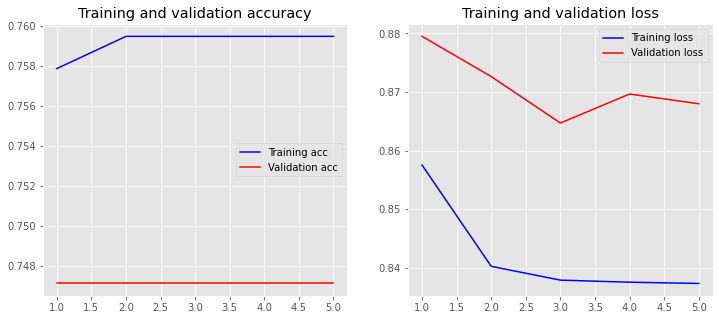

In [30]:
# # Train the LSTM model
history4 = model5.fit(data_padded_train, y_train2, epochs=20, validation_data=(data_padded_val, y_val2), callbacks=[early_stopping])

loss5,accuracy5 = model5.evaluate(data_padded_train, y_train2, verbose = False)
print("Training Accuracy: {:.4f}".format(accuracy5))
loss5,accuracy5 = model5.evaluate(data_padded_test, y_test2, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy5))


plot_history(history4)

In [31]:
# Bidirectional LSTM model
model6 = Sequential()
model6.add(Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], input_length=100, trainable=True))
model6.add(Bidirectional(LSTM(128)))
model6.add(Dropout(0.2))
model6.add(Dense(5, activation='softmax'))
model6.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model6.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 300)          6030000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              439296    
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 6,470,581
Trainable params: 6,470,581
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
350/350 [==============================] - 95s 250ms/step - loss: 0.7677 - accuracy: 0.7671 - val_loss: 0.8041 - val_accuracy: 0.7707
Epoch 2/20
350/350 [==============================] - 87s 247ms/step - loss: 0.5952 - accuracy: 0.8025 - val_loss: 0.7017 - val_accuracy: 0.7807
Epoch 3/20
350/350 [==============================] - 85s 243ms/step - loss: 0.4850 - accuracy: 0.8328 - val_loss: 0.7035 - val_accuracy: 0.7621
Epoch 4/20
350/350 [==============================] - 86s 246ms/step - loss: 0.3712 - accuracy: 0.8702 - val_loss: 0.7698 - val_accuracy: 0.7671
Training Accuracy: 0.8162
Testing Accuracy:  0.7900


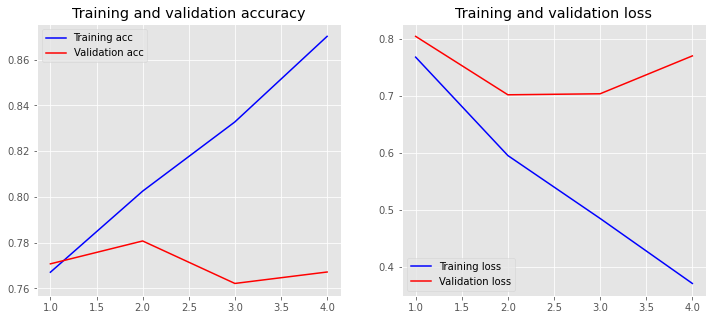

In [32]:
history5 = model6.fit(data_padded_train, y_train2, epochs=20, validation_data=(data_padded_val, y_val2), callbacks=[early_stopping])

loss6,accuracy6 = model6.evaluate(data_padded_train, y_train2, verbose = False)
print("Training Accuracy: {:.4f}".format(accuracy6))
loss6,accuracy6 = model6.evaluate(data_padded_test, y_test2, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy6))


plot_history(history5)